In [1]:
import ta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import mplfinance as mpf
import tqdm

In [2]:
datatrain = pd.read_csv("aapl_5m_train.csv")
dataval = pd.read_csv('aapl_5m_validation.csv')
datatrain.head()

,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,1641220200,0,2022-01-03 14:30:00,177.830001,179.309997,177.710006,178.964996,4441780.0
1,1641220500,0,2022-01-03 14:35:00,178.970001,180.399993,178.919998,180.330001,2482136.0
2,1641220800,0,2022-01-03 14:40:00,180.330001,180.839996,180.210006,180.595001,2219825.0
3,1641221100,0,2022-01-03 14:45:00,180.600006,180.750000,179.470001,179.940002,2018163.0
4,1641221400,0,2022-01-03 14:50:00,179.929992,180.229904,179.399993,180.210006,1944837.0


In [3]:
class Order:
    def __init__(self, timestamp, bought_at, stop_loss, take_profit, order_type, sold_at = None, 
                 is_active: bool = True):
        self.timestmap = timestamp
        self.bought_at = bought_at
        self.sold_at = sold_at
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.order_type = order_type
        self.is_active = is_active

    def __repr__(self) -> str:
        return f"{self.order_type} Position - id {self.timestamp}"
    
    def __str__(self) -> str:
        return f"{self.order_type} {self.is_active} Position @ {self.bought_at}"

In [4]:
def test_strategy(datatrain, sl_val, tp_val, sma_s, sma_l, win_s, win_f, win_si, rsi_v,
                  rsi_l, rsi_h, ema_s, ema_l, bol_val):
    #Choosing indicators
    short_sma= ta.trend.SMAIndicator(datatrain.Close, window=sma_s)
    long_sma= ta.trend.SMAIndicator(datatrain.Close, window=sma_l)
    macd = ta.trend.MACD(datatrain.Close, window_slow = win_s,
        window_fast = win_f,
        window_sign = win_si,
        fillna = False)

    rsi = ta.momentum.RSIIndicator(datatrain.Close, window = rsi_v,
        fillna = False,)

    short_ema = ta.trend.EMAIndicator(datatrain.Close, window=ema_s)
    long_ema = ta.trend.EMAIndicator(datatrain.Close, window=ema_l)

    bollinger_bands = ta.volatility.BollingerBands(datatrain.Close, window=bol_val, window_dev=2)
    
    #Create columns with indicators
    datatrain["short_sma"] = short_sma.sma_indicator()
    datatrain["long_sma"] = long_sma.sma_indicator()
    datatrain['MACD'] = macd.macd()
    datatrain['MACDS'] = macd.macd_signal()
    datatrain["RSI"] = rsi.rsi()
    datatrain["long_ema"] = long_ema.ema_indicator()
    datatrain["short_ema"] = short_ema.ema_indicator()
    datatrain["bollinger"] = bollinger_bands.bollinger_mavg()
    
    #Set the Buy and Sell signals
    datatrain['buy_signal_sma'] = datatrain.short_sma < datatrain.long_sma
    datatrain['sell_signal_sma'] = datatrain.short_sma > datatrain.long_sma

    datatrain['buy_signal_ema'] = datatrain.short_ema < datatrain.long_ema
    datatrain['sell_signal_ema'] = datatrain.short_ema > datatrain.long_ema

    datatrain['buy_signal_rsi'] = datatrain.RSI == rsi_l
    datatrain['sell_signal_rsi'] = datatrain.RSI == rsi_h

    datatrain['buy_signal_bollinger'] = datatrain.bollinger < datatrain.Close
    datatrain['sell_signal_bollinger'] = datatrain.bollinger > datatrain.Close

    datatrain['buy_signal_MACD'] = datatrain.MACD > 0
    datatrain['sell_signal_MACD'] = datatrain.MACD < 0
    
    COMMISSION = 0.0025 #for this case
    STOP_LOSS = sl_val
    TAKE_PROFIT = tp_val
    cash = 1_000_000
    positions = []
    closed_positions = []

    long_operations = []
    short_operations = []

    for i, row in datatrain.iterrows():       

        if cash < 0:
            print("AAAAAAAA")
            continue

        #Close positions
        price = row.Close
        for position in positions:
            j = positions.index(position)
            if position.is_active:
                if position.order_type == "LONG":
                    if price <= position.stop_loss:
                        # print("CLOSED LONG")
                        cash += price * (1-COMMISSION)
                        position.is_active = False 
                        position.sold_at = price
                        closed_positions.append(position)
                        positions.pop(j)
                        # print(f"Closing active position - Bought at {position.bought_at}"+
                        #      f"- Sold at {position.sold_at}")


                    elif price >= position.take_profit:
                        # print("CLOSED LONG")
                        cash += price * (1-COMMISSION)
                        position.is_active = False 
                        position.sold_at = price
                        closed_positions.append(position)
                        positions.pop(j)
                        # print(f"Closing active position - Bought at {position.bought_at}"+
                        #          f"- Sold at {position.sold_at}")
                else:
                    if price >= position.stop_loss:
                        cash -= price * (1-COMMISSION)
                        position.is_active = False 
                        position.sold_at = price
                        closed_positions.append(position)
                        positions.pop(j)
                        # print(f"(LOSS) - Closing short position - Bought at {position.bought_at}"+
                        #       f"- Sold at {position.sold_at}")


                    elif price <= position.take_profit:
                        cash -= price * (1-COMMISSION)
                        position.is_active = False 
                        position.sold_at = price
                        closed_positions.append(position)
                        positions.pop(j)
                        # print(f"(PROFIT) - Closing short position - Bought at {position.bought_at}"+
                        #       f"- Sold at {position.sold_at}")

                    if (price + 2 * (position.bought_at - price)) > cash:
                        cash -= price * (1-COMMISSION)
                        position.is_active = False 
                        position.sold_at = price
                        closed_positions.append(position)
                        positions.pop(j)
                        # Close position
                        # print(f"(MARGIN CALL) - Closing short position - Bought at {position.bought_at}"+
                        #       f"- Sold at {position.sold_at}")

    #Signals
    # buy_signal_sma, buy_signal_ema, buy_signal_rsi, buy_signal_bollinger, buy_signal_MACD
    # sell_signal_sma, sell_signal_ema, sell_signal_rsi, sell_signal_bollinger, sell_signal_MACD

        #Buy
        buy_signals = [row.buy_signal_sma, row.buy_signal_ema, row.buy_signal_rsi, row.buy_signal_bollinger, row.buy_signal_MACD]
        if sum(buy_signals) >= 4:
            if cash < row.Close*(1+COMMISSION):
                continue
            cash -= row.Close*(1+COMMISSION)
            order = Order(
                timestamp = row.Timestamp,
                bought_at = row.Close,
                stop_loss = row.Close*(1-STOP_LOSS),
                take_profit = row.Close*(1+TAKE_PROFIT),
                order_type = "LONG"
            )
            positions.append(order)
            long_operations.append(1)



       #Sell     
        sell_signals = [row.sell_signal_sma, row.sell_signal_ema, row.sell_signal_rsi, row.sell_signal_bollinger, row.sell_signal_MACD]
        if sum(sell_signals) >= 4:
            if cash < row.Close * (1+COMMISSION):
                continue
            cash += row.Close*(1-COMMISSION)
            order = Order(
                timestamp = row.Timestamp,
                bought_at = row.Close,
                stop_loss = row.Close*(1+STOP_LOSS),
                take_profit = row.Close*(1-TAKE_PROFIT),
                order_type = "SHORT"
            )
            positions.append(order)
            short_operations.append(1)
    
    for position in positions:
        j = positions.index(position)
        if position.is_active:
            if position.order_type == "LONG":
                cash += price * (1-COMMISSION)
                position.is_active = False 
                position.sold_at = price
                closed_positions.append(position)
                positions.pop(j)

            else:
                cash -= price * (1-COMMISSION)
                position.is_active = False 
                position.sold_at = price
                closed_positions.append(position)
                positions.pop(j)
    
    return cash

    


In [5]:
sl_values = np.random.uniform(0.01, 0.1, 100)
tp_values = np.random.uniform(0.01, 0.1, 100)

short_sma_values = np.random.randint(5, 25, 100)
long_sma_values = np.random.randint(26, 80, 100)

win_slow_macd_values = np.random.randint(13, 26, 100)
win_fast_macd_values = np.random.randint(10, 12, 100)
win_sign_macd_values = np.random.randint(1, 9, 100)

rsi_window = np.random.randint(10, 25, 100)
rsi_low = np.random.randint(5, 45, 100)
rsi_high = np.random.randint(55, 95, 100)

short_ema_values = np.random.randint(1, 10, 100)
long_ema_values = np.random.randint(11, 30, 100)

bol_bands_values = np.random.randint(10, 80, 100)

parameters = []
portfolio_values = []

for i in tqdm.tqdm(range(100)): 
    sl_val = sl_values[i]
    tp_val = tp_values[i]
    sma_s = short_sma_values[i]
    sma_l = long_sma_values[i]
    win_s = win_slow_macd_values[i]
    win_f = win_fast_macd_values[i]
    win_si = win_sign_macd_values[i]
    rsi_v = rsi_window[i]
    rsi_l = rsi_low[i]
    rsi_h = rsi_high[i]
    ema_s = short_ema_values[i]
    ema_l = long_ema_values[i]
    bol_val = bol_bands_values[i]

    parameters.append([sl_val, tp_val, sma_s, sma_l, win_s, win_f, win_si, rsi_v, rsi_l, rsi_h, ema_s, ema_l, bol_val])
    
    portfolio_value = test_strategy(datatrain.copy(), sl_val, tp_val, sma_s, sma_l, win_s, win_f, win_si,
                                    rsi_v, rsi_l, rsi_h, ema_s, ema_l, bol_val)
    portfolio_values.append(portfolio_value)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.83s/it]


In [6]:
best_portfolio = np.argmax(portfolio_values)

print(f"Best Portfolio value = {portfolio_values[best_portfolio]}")
print(parameters[best_portfolio])

Best Portfolio value = 1000902.3054683324
[0.032549879514278, 0.04930511153907315, 5, 27, 25, 11, 1, 16, 16, 93, 4, 18, 49]


In [9]:
rend_notrade = (datatrain['Close'].iloc[-1] - datatrain['Close'].iloc[0]) / datatrain['Close'].iloc[0]
rend_portfolio = (portfolio_values[best_portfolio] - 1000000) / 1000000


print(f"El rendimiento sin trade es: {rend_notrade*100:.2f}%")
print(f"El rendimiento de nuestro portafolio es: {rend_portfolio*100:.2f}%")

El rendimiento sin trade es: -27.40%
El rendimiento de nuestro portafolio es: 0.09%


## Define buy/sell signals for each indicator.

## Create all possible combinations of all technical indicators: 2^n - 1

In [19]:
# List of indicator column names
indicator_columns = [
    "short_sma",
    "long_sma",
    "MACD",
    "MACDS",
    "RSI",
    "long_ema",
    "short_ema",
    "bollinger",
]

# Generate all possible combinations of indicator columns (2^n - 1 combinations)
all_indicator_combinations = set()

# Loop through different numbers of indicators (from 1 to the total number of indicators)
for num_indicators in range(1, len(indicator_columns) + 1):
    # Generate all combinations of indicator columns for the current number of indicators
    combinations = itertools.combinations(indicator_columns, num_indicators)
    
    # Add the combinations to the set (duplicates will be automatically removed)
    all_indicator_combinations.update(combinations)

# Convert the set of combinations to a list of lists for easier access
all_indicator_combinations = [list(combination) for combination in all_indicator_combinations]

# Print all unique indicator combinations
for combination in all_indicator_combinations:
#    print(combination)


IndentationError: expected an indented block (Temp/ipykernel_24724/3977246755.py, line 29)

## Backtest the strategies while keeping track of the operations and cash/portfolio value time series.

## Optimize all technical indicator's parameters, stop-loss/take-profit, volume of the trade, maximizing the profit of the strategy with the training dataset, consider the bounds of each variable!

C:\ANACONDA3\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


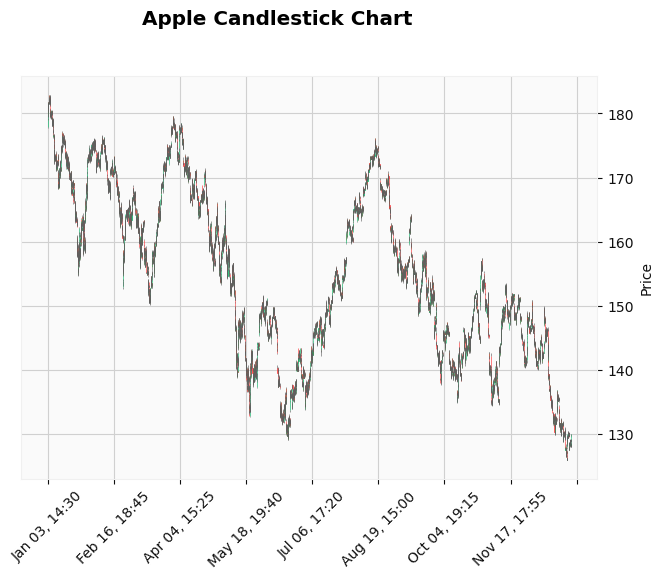

In [20]:
# Convert the 'Date' column to a datetime format if it's not already
datatrain['Datetime'] = pd.to_datetime(datatrain['Datetime'])

# Set the 'Date' column as the index
datatrain.set_index('Datetime', inplace=True)

# Create a candlestick chart
mpf.plot(datatrain, type='candle', style='yahoo', title="Apple Candlestick Chart", ylabel="Price")

## Select the optimal strategy and describe it thoroughly (what indicators are used, when is the trade signal produced, etc.).

## Now, use the optimal strategy with the validation dataset and compare it to a passive strategy.

## Our revenue

In [24]:
short_sma2 = ta.trend.SMAIndicator(dataval.Close, window=5)
long_sma2 = ta.trend.SMAIndicator(dataval.Close, window=27)
macd2 = ta.trend.MACD(dataval.Close, window_slow = 25,
    window_fast = 11,
    window_sign = 1,
    fillna = False)
rsi2 = ta.momentum.RSIIndicator(dataval.Close, window = 16,
    fillna = False,)



short_ema2 = ta.trend.EMAIndicator(dataval.Close, window=4)
long_ema2 = ta.trend.EMAIndicator(dataval.Close, window=18)

bollinger_bands2 = ta.volatility.BollingerBands(dataval.Close, window=49, window_dev=2)


#Create columns with indicators
dataval["short_sma2"] = short_sma2.sma_indicator()
dataval["long_sma2"] = long_sma2.sma_indicator()
dataval['MACD2'] = macd2.macd()
dataval['MACDS2'] = macd2.macd_signal()
dataval["RSI2"] = rsi2.rsi()
dataval["long_ema2"] = long_ema2.ema_indicator()
dataval["short_ema2"] = short_ema2.ema_indicator()
dataval["bollinger2"] = bollinger_bands2.bollinger_mavg()

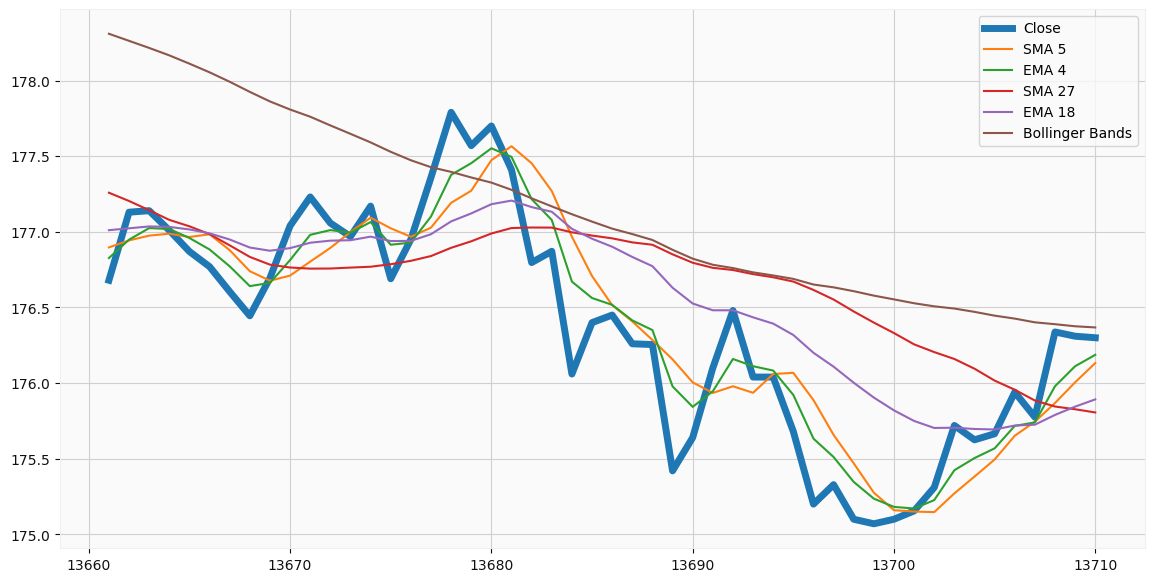

In [25]:
plt.figure(figsize=(14, 7))
plt.grid(True)
plt.plot(dataval.Close[-50:], label = 'Close', linewidth = 5)
plt.plot(dataval.short_sma2[-50:], label = 'SMA 5')
plt.plot(dataval.short_ema2[-50:], label = 'EMA 4')
plt.plot(dataval.long_sma2[-50:], label = 'SMA 27')
plt.plot(dataval.long_ema2[-50:], label = 'EMA 18')
plt.plot(dataval.bollinger2[-50:], label = 'Bollinger Bands')
plt.legend();
plt.show()

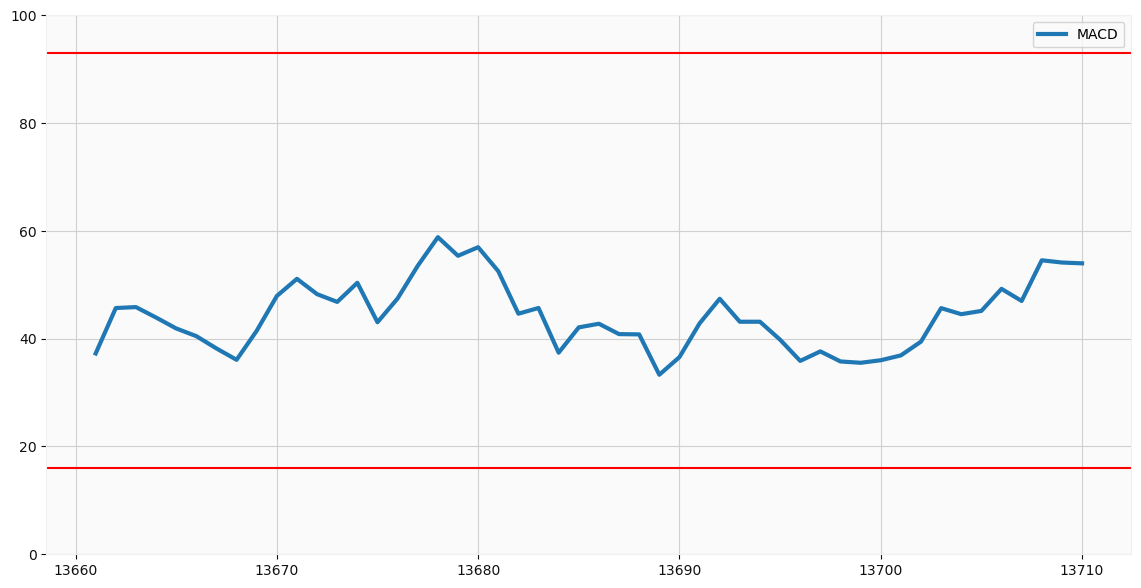

In [26]:
plt.figure(figsize=(14, 7))
plt.grid(True)
plt.plot(dataval.RSI[-50:], label = 'MACD', linewidth = 3)
plt.axhline(y=16, color = 'r', linestyle = '-')
plt.axhline(y=93, color = 'r', linestyle = '-')
plt.legend()
plt.ylim(0,100)
plt.show()

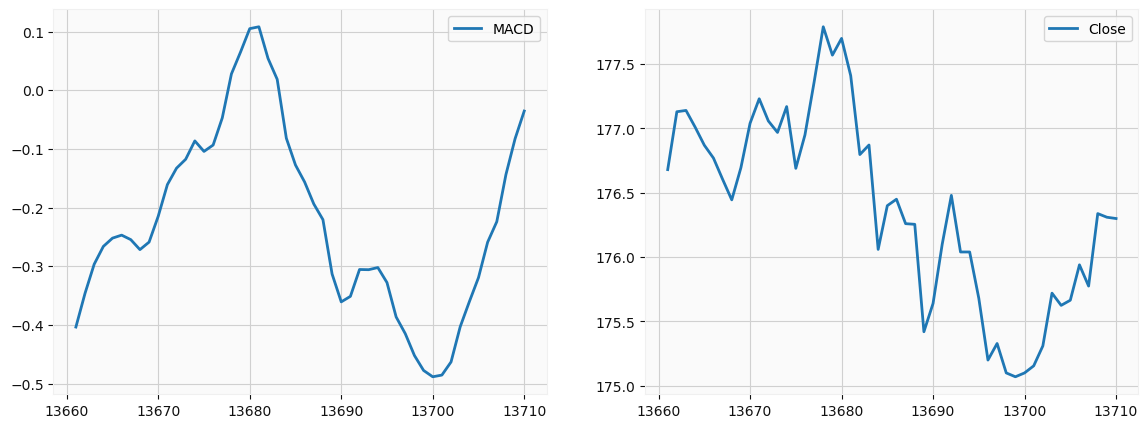

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: MACD
axs[0].grid(True)
axs[0].plot(dataval.MACD2[-50:], label='MACD', linewidth=2)
axs[0].legend()

# Second subplot: Close
axs[1].grid(True)
axs[1].plot(dataval.Close[-50:], label='Close', linewidth=2)
axs[1].legend()

plt.show()

In [29]:
#Set the Buy and Sell signals
dataval['buy_signal_sma2'] = dataval.short_sma2 < dataval.long_sma2
dataval['sell_signal_sma2'] = dataval.short_sma2 > dataval.long_sma2

dataval['buy_signal_ema2'] = dataval.short_ema2 < dataval.long_ema2
dataval['sell_signal_ema2'] = dataval.short_ema2 > dataval.long_ema2

dataval['buy_signal_rsi2'] = dataval.RSI2 == 16
dataval['sell_signal_rsi2'] = dataval.RSI2 == 93

dataval['buy_signal_bollinger2'] = dataval.bollinger2 < dataval.Close
dataval['sell_signal_bollinger2'] = dataval.bollinger2 > dataval.Close

dataval['buy_signal_MACD2'] = dataval.MACD2 > 0
dataval['sell_signal_MACD2'] = dataval.MACD2 < 0

In [46]:
class Order2:
    def __init__(self2, timestamp2, bought_at2, stop_loss2, take_profit2, order_type2, sold_at2 = None, 
                 is_active2: bool = True):
        self2.timestmap2 = timestamp2
        self2.bought_at2 = bought_at2
        self2.sold_at2 = sold_at2
        self2.stop_loss2 = stop_loss2
        self2.take_profit2 = take_profit2
        self2.order_type2 = order_type2
        self2.is_active2 = is_active2

    def __repr__(self2) -> str:
        return f"{self2.order_type2} Position - id {self.timestamp2}"
    
    def __str__(self2) -> str:
        return f"{self.order_type2} {self.is_active2} Position @ {self.bought_at2}"

In [69]:
COMMISSION2 = 0.0025 #for this case
STOP_LOSS2 = 0.032549879514278
TAKE_PROFIT2 = 0.04930511153907315
cash2 = 1_000_000
positions2 = []
closed_positions2 = []

long_operations2 = []
short_operations2 = []

for i, row in dataval.iterrows():       

    if cash2 < 0:
        print("AAAAAAAA")
        continue

    #Close positions
    price2 = row.Close
    for position2 in positions2:
        j = positions2.index(position2)
        if position2.is_active2:
            if position2.order_type2 == "LONG":
                if price2 <= position2.stop_loss2:
                    # print("CLOSED LONG")
                    cash2 += price2 * (1-COMMISSION2)
                    position2.is_active2 = False 
                    position2.sold_at2 = price2
                    closed_positions2.append(position2)
                    positions2.pop(j)
                    # print(f"Closing active position - Bought at {position.bought_at}"+
                    #      f"- Sold at {position.sold_at}")


                elif price2 >= position2.take_profit2:
                    # print("CLOSED LONG")
                    cash2 += price2 * (1-COMMISSION2)
                    position2.is_active2 = False 
                    position2.sold_at2 = price2
                    closed_positions2.append(position2)
                    positions2.pop(j)
                    # print(f"Closing active position - Bought at {position.bought_at}"+
                    #          f"- Sold at {position.sold_at}")
            else:
                if price2 >= position2.stop_loss2:
                    cash2 -= price2 * (1-COMMISSION2)
                    position2.is_active2 = False 
                    position2.sold_at2 = price2
                    closed_positions2.append(position2)
                    positions2.pop(j)
                    # print(f"(LOSS) - Closing short position - Bought at {position.bought_at}"+
                    #       f"- Sold at {position.sold_at}")


                elif price2 <= position2.take_profit2:
                    cash2 -= price2 * (1-COMMISSION2)
                    position2.is_active2 = False 
                    position2.sold_at2 = price2
                    closed_positions2.append(position2)
                    positions2.pop(j)
                    # print(f"(PROFIT) - Closing short position - Bought at {position.bought_at}"+
                    #       f"- Sold at {position.sold_at}")

                if (price2 + 2 * (position2.bought_at2 - price2)) > cash2:
                    cash2 -= price2 * (1-COMMISSION2)
                    position2.is_active2 = False 
                    position2.sold_at2 = price2
                    closed_positions2.append(position2)
                    positions2.pop(j)
                    # Close position
                    # print(f"(MARGIN CALL) - Closing short position - Bought at {position.bought_at}"+
                    #       f"- Sold at {position.sold_at}")

#Signals
# buy_signal_sma, buy_signal_ema, buy_signal_rsi, buy_signal_bollinger, buy_signal_MACD
# sell_signal_sma, sell_signal_ema, sell_signal_rsi, sell_signal_bollinger, sell_signal_MACD

    #Buy
buy_signals2 = [row.buy_signal_sma2, row.buy_signal_ema2, row.buy_signal_rsi2, row.buy_signal_bollinger2, row.buy_signal_MACD2]
if sum(buy_signals2) >= 4:
    if cash2 < row.Close*(1+COMMISSION2):
        #continue
        cash2 -= row.Close*(1+COMMISSION2)
        order2 = Order2(
        timestamp2 = row.Timestamp,
        bought_at2 = row.Close,
        stop_loss2 = row.Close*(1-STOP_LOSS2),
        take_profit2 = row.Close*(1+TAKE_PROFIT2),
        order_type2 = "LONG"
    )
    positions2.append(order2)
    long_operations2.append(1)



   #Sell     
sell_signals2 = [row.sell_signal_sma2, row.sell_signal_ema2, row.sell_signal_rsi2, row.sell_signal_bollinger2, row.sell_signal_MACD2]
if sum(sell_signals2) >= 4:
    if cash2 < row.Close * (1+COMMISSION2):
        #continue
        cash2 += row.Close*(1-COMMISSION2)
        order2 = Order2(
        timestamp2 = row.Timestamp,
        bought_at2 = row.Close,
        stop_loss2 = row.Close*(1+STOP_LOSS2),
        take_profit2 = row.Close*(1-TAKE_PROFIT2),
        order_type2 = "SHORT"
    )
    positions2.append(order2)
    short_operations2.append(1)

for position2 in positions2:
    j2 = positions2.index(position2)
    if position2.is_active2:
        if position2.order_type2 == "LONG":
            cash2 += price2 * (1-COMMISSION2)
            position2.is_active2 = False 
            position2.sold_at2 = price2
            closed_positions2.append(position2)
            positions2.pop(j2)

        else:
            cash2 -= price2 * (1-COMMISSION2)
            position2.is_active2 = False 
            position2.sold_at2 = price2
            closed_positions2.append(position2)
            positions2.pop(j2)

return cash2


SyntaxError: 'return' outside function (Temp/ipykernel_24724/3789332590.py, line 128)

In [70]:
rend_notrade2 = (dataval['Close'].iloc[-1] - dataval['Close'].iloc[0]) / dataval['Close'].iloc[0]
rend_portfolio2 = (cash2 - 1000000) / 1000000


print(f"El rendimiento sin trade es: {rend_notrade2*100:.2f}%")
print(f"El rendimiento de nuestro portafolio es: {rend_portfolio2*100:.2f}%")

El rendimiento sin trade es: 35.78%
El rendimiento de nuestro portafolio es: 0.00%


## Present the results & conclusions in a Jupyter notebook (without unnecessary code, only plot-related things), include the list of the operations, candlestick charts, indicators, trading signals, cash through time, portfolio value through time, and any other chart that you consider important.